- Adapt the code for pretrained nets to work with Resnet50

# Load libraries

## Pretrained nets

https://keras.io/applications/

In [2]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
### prepare a model with Resnet50
from keras import backend as K

# image processing
from keras.preprocessing import image as image_utils 
from keras.preprocessing.image import img_to_array

# pretrained nets
from keras.applications.resnet50 import ResNet50 #ResNet50 is the pretrained model in this case
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [4]:
train_image_files_path = "/keras2production/fruits/Training/"
valid_image_files_path = "/keras2production/fruits/Test/"

In [5]:
model_resnet50 = ResNet50(weights='imagenet')

In [6]:
model_resnet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [7]:
def classify_image(image):
    img = cv2.imread(image)      # default read in is BGR - different colour channel order  
    b,g,r = cv2.split(img)       # get b,g,r
    img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(img)
    plt.xticks([]), plt.yticks([]) # no axis needed here
    plt.show()                     # show the images
    
    # images need to be numpy arrays of 224 x 224 color images with 3 channels
    image = image_utils.load_img(image, target_size=(224, 224)) ## keras function to load the images
    # this step above is needed to fit the image the size that is expected by keras
    
    # turn it into an array
    image = image_utils.img_to_array(image)

    # expand the dimensions to be (1, 3, 224, 224) # adding a fake dimension - using numpy (np)
    image = np.expand_dims(image, axis=0)

    # scale pixels between -1 and 1, sample-wise
    # always know what you did to the images before feeding it to the keras function
    image = preprocess_input(image)
        
    preds = model_resnet50.predict(image) # apply the model to the image
    
    # decode predictions - keras calculates indexes and this has to 
    # be decoded to human understandable prediction result
    res = decode_predictions(preds, top=3)
    
    for (i, (imagenetID, label, prob)) in enumerate(res[0]):
        print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

In [8]:
train_images = !find $train_image_files_path -type f -name "*.jpg"

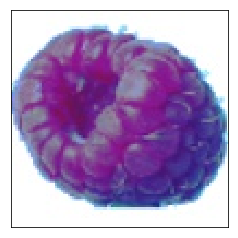

1. hair_slide: 8.93%
2. lotion: 6.58%
3. face_powder: 6.48%


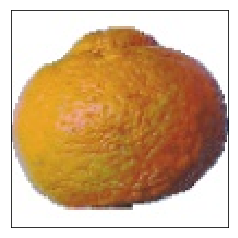

1. orange: 76.23%
2. lemon: 7.87%
3. jackfruit: 3.07%


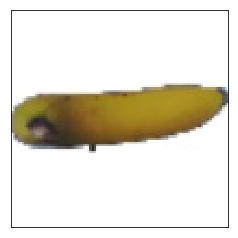

1. banana: 45.17%
2. can_opener: 10.71%
3. stretcher: 7.80%


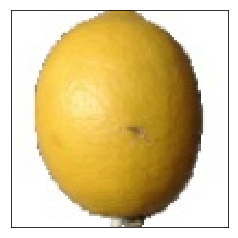

1. lemon: 85.34%
2. croquet_ball: 3.51%
3. maraca: 3.30%


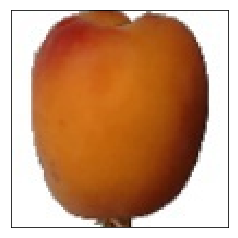

1. drum: 15.13%
2. spaghetti_squash: 10.92%
3. punching_bag: 8.69%


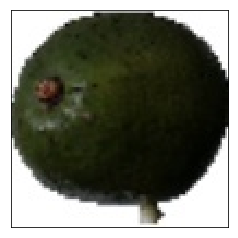

1. custard_apple: 34.25%
2. gong: 29.48%
3. fig: 8.50%


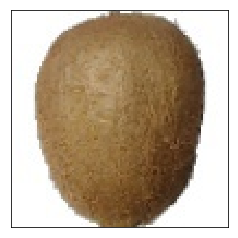

1. maraca: 14.45%
2. gong: 14.07%
3. chime: 11.91%


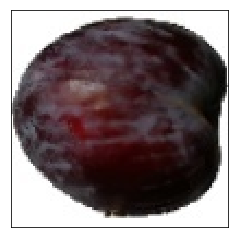

1. fig: 18.33%
2. maraca: 17.06%
3. electric_ray: 11.75%


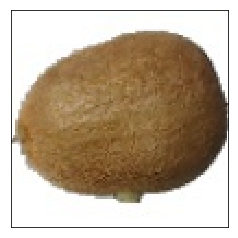

1. electric_ray: 31.13%
2. gong: 16.26%
3. maraca: 12.31%


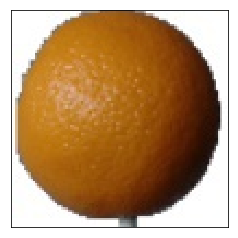

1. orange: 72.52%
2. lemon: 23.17%
3. croquet_ball: 1.04%


In [17]:
num = 10
train_images_r = random.sample(train_images, num)
for i in range(num):
    classify_image(train_images_r[i])

# Visualise

In [18]:
train_images_r

['/keras2production/fruits/Training/Raspberry/r_245_100.jpg',
 '/keras2production/fruits/Training/Mandarine/279_100.jpg',
 '/keras2production/fruits/Training/Banana/r_312_100.jpg',
 '/keras2production/fruits/Training/Lemon/188_100.jpg',
 '/keras2production/fruits/Training/Apricot/111_100.jpg',
 '/keras2production/fruits/Training/Avocado/r_156_100.jpg',
 '/keras2production/fruits/Training/Kiwi/162_100.jpg',
 '/keras2production/fruits/Training/Plum/r_218_100.jpg',
 '/keras2production/fruits/Training/Kiwi/r_216_100.jpg',
 '/keras2production/fruits/Training/Orange/r_243_100.jpg']

In [19]:
img = image_utils.load_img(train_images_r[2], target_size=(224, 224))
# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image_utils.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

preds = model_resnet50.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n07753592', 'banana', 0.4516685), ('n02951585', 'can_opener', 0.107142545), ('n04336792', 'stretcher', 0.07803904)]


In [20]:
# here you can extract the tensor for the banana - for example
banana_output = model_resnet50.output[:, np.argmax(preds[0])]
banana_output

<tf.Tensor 'strided_slice:0' shape=(?,) dtype=float32>

In [27]:
# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGGG16
last_conv_layer = model_resnet50.get_layer('bn5c_branch2c')
last_conv_layer

In [28]:
# This is the gradient of the class with regard to
# the output feature map of `fc1000`
grads = K.gradients(banana_output, last_conv_layer.output)[0]
grads

<tf.Tensor 'gradients_1/add_16/add_grad/Reshape:0' shape=(?, 7, 7, 2048) dtype=float32>

In [29]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))
pooled_grads

<tf.Tensor 'Mean_3:0' shape=(2048,) dtype=float32>

In [30]:
iterate = K.function([model_vgg.input], [pooled_grads, last_conv_layer.output[0]])
iterate

NameError: name 'model_vgg' is not defined